# Convolutional Neural Networks - CNN

Training a CNN to classify images from the **CIFAR-10** database. CIFAR-10 contains small color images that fall into one of ten classes.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

# convert data to a normalized torch.FloatTensor
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10('~/.pytorch', train=True, download=True, transform=normalize)
test_set = datasets.CIFAR10('~/.pytorch', train=False, download=True, transform=normalize)

# we split randomly 20% from the trainset into a validation set
train_set, validation_set = random_split(dataset, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(f'train_set: {len(train_set)} images')
print(f'validation_set: {len(validation_set)} images')
print(f'test_set: {len(test_set)} images')

train_set: 40000 images
validation_set: 10000 images
test_set: 10000 images


In [4]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [5]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

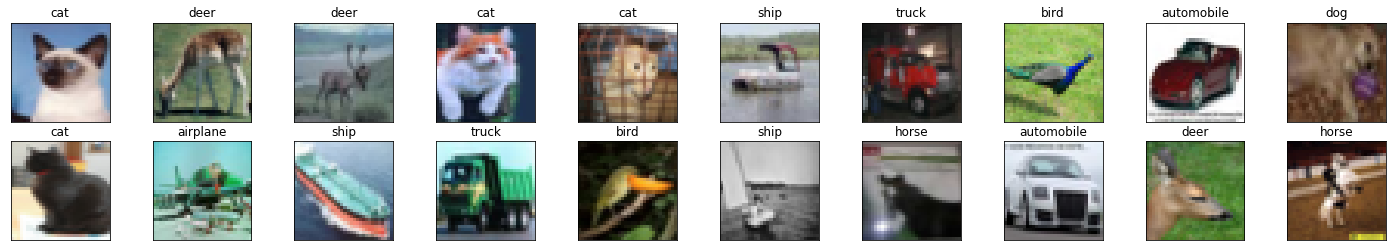

In [6]:
images, labels = next(iter(train_loader))         # first batch of 20 images

def imshow(img):
    img = img / 2 + 0.5                           # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))      # convert from torch.Size([3, 32, 32]) to torch.Size([32, 32, 3])
    
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size / 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Network Architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)     # sees 32 x 32 x 3 image tensor
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)    # sees 16 x 16 x 16 tensor
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)    # sees 8 x 8 x 32 tensor
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 4 * 64)                       # flatten image input
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        return x

model = CNN().to(device)

summary(model, input_size=(3, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

### Specify Loss Function and Optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Network

### Training algorithm

For each **training batch** (of size `batch_size`), we

1. clear the gradients of all optimized variables with `optimizer.zero_grad()`

2. compute predicted outputs by passing inputs to the model with `model(data)`

3. calculate the **batch loss** with `criterion(output, target)` (average of all losses within the batch)

4. compute gradient of the loss with respect to model parameters with `loss.backward()`

5. perform a single optimization step by updating the parameter with `optimizer.step()`

6. sum up the loss for each **sample** (`loss * batch_size`)

Then we calculate the **loss** of each **validation batch** (without calculating the gradients) for comparison.

Finally we calculate the **training loss** and **validation loss** for **one epoche**.

In [9]:
import time
start = time.time()

epochs = 50

validation_loss_min = np.Inf                     # track change in validation loss, we start with a loss of infinity

train_loss_history = []
validation_loss_history = []

for epoch in range(1, epochs + 1):

    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size
        
    model.eval()
    for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        validation_loss += loss.item() * batch_size
    
    # average losses for current epoch
    train_loss = train_loss / len(train_set)
    train_loss_history.append(train_loss)
    
    validation_loss = validation_loss / len(validation_set)
    validation_loss_history.append(validation_loss)
        
    # print training / validation statistics 
    print(f'Epoch: {epoch}\tTraining Loss: {train_loss:.6f} \tValidation Loss: {validation_loss:.6f}')
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print(f'Validation loss decreased. Saving model ...')
        torch.save(model.state_dict(), 'model_cifar.pt')
        validation_loss_min = validation_loss

end = time.time()
print(f'TRAIN TIME: {(end - start):.1f} sec')

Epoch: 1	Training Loss: 2.228008 	Validation Loss: 2.024299
Validation loss decreased. Saving model ...
Epoch: 2	Training Loss: 1.754428 	Validation Loss: 1.590259
Validation loss decreased. Saving model ...
Epoch: 3	Training Loss: 1.528141 	Validation Loss: 1.435990
Validation loss decreased. Saving model ...
Epoch: 4	Training Loss: 1.394937 	Validation Loss: 1.320808
Validation loss decreased. Saving model ...
Epoch: 5	Training Loss: 1.294665 	Validation Loss: 1.226307
Validation loss decreased. Saving model ...
Epoch: 6	Training Loss: 1.206696 	Validation Loss: 1.137987
Validation loss decreased. Saving model ...
Epoch: 7	Training Loss: 1.131365 	Validation Loss: 1.065167
Validation loss decreased. Saving model ...
Epoch: 8	Training Loss: 1.066689 	Validation Loss: 1.028640
Validation loss decreased. Saving model ...
Epoch: 9	Training Loss: 1.011028 	Validation Loss: 0.959475
Validation loss decreased. Saving model ...
Epoch: 10	Training Loss: 0.956581 	Validation Loss: 0.942956
Val

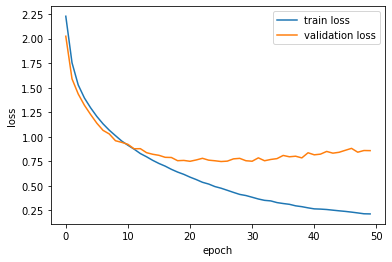

In [10]:
plt.plot(train_loss_history, label='train loss')
plt.plot(validation_loss_history, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

###  Load the Model

In [11]:
model.load_state_dict(torch.load('model_cifar.pt'));

## Test the Trained Network

In [12]:
class_correct = list(0 for i in range(10))  # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_total = list(0 for i in range(10))

model.eval()    # don't calculate gradients

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, pred = output.max(dim=1)
    correct_tensor = pred.eq(target)
    correct = correct_tensor.cpu().numpy() if device.type == 'cpu' else correct_tensor.numpy()

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i]  # adds 1 if True, adds 0 if False
        class_total[label] += 1

# accuracy for each class
for i in range(len(classes)):
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]:10} : {accuracy:.2%} [{class_correct[i]}/{class_total[i]}]')
    else:
        print(f'Test Accuracy of {classes[i]:10} : N/A (no training examples)')

# accuracy over all classes
accuracy = np.sum(class_correct) / np.sum(class_total)
print(f'Test Accuracy (Overall)     : {accuracy:.2%} [{np.sum(class_correct)}/{np.sum(class_total)}]')

Test Accuracy of airplane   : 77.40% [774/1000]
Test Accuracy of automobile : 89.10% [891/1000]
Test Accuracy of bird       : 66.80% [668/1000]
Test Accuracy of cat        : 53.50% [535/1000]
Test Accuracy of deer       : 78.10% [781/1000]
Test Accuracy of dog        : 51.40% [514/1000]
Test Accuracy of frog       : 86.40% [864/1000]
Test Accuracy of horse      : 73.80% [738/1000]
Test Accuracy of ship       : 86.60% [866/1000]
Test Accuracy of truck      : 75.40% [754/1000]
Test Accuracy (Overall)     : 73.85% [7385/10000]


### Visualize Test Images

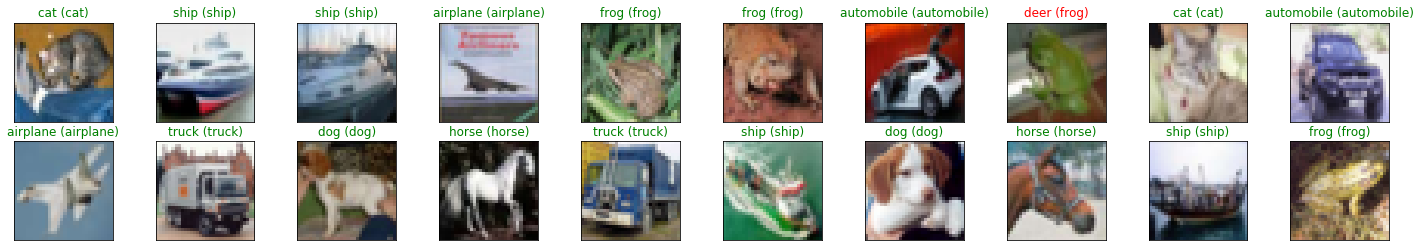

In [13]:
images, labels = next(iter(test_loader))  # one batch
if not device.type == 'cpu':
    images = images.cuda()

output = model(images)
_, p = output.max(1)
preds = p.cpu().numpy() if device.type == 'cpu' else p.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size / 2, idx + 1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title(f'{classes[preds[idx]]} ({classes[labels[idx]]})', color=('green' if preds[idx] == labels[idx].item() else 'red'))